# Medical Examiner Case Archives

Cook County (Chicago) medical examiner records, taken from [here](https://datacatalog.cookcountyil.gov/Public-Safety/Medical-Examiner-Case-Archive/cjeq-bs86) after discovery via [Data is Plural](https://tinyletter.com/data-is-plural).

## Do your importing/setup

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline

## Read in the data, check its row count and column types

In [2]:
!ls

case-archive-encoded.csv
Medical Examiner.ipynb
Medical_Examiner_Case_Archive.csv


In [3]:
df = pd.read_csv("case-archive-encoded.csv", na_values=["Nan", -1])

In [4]:
df.head()

,Case Number,Date of Incident,Date of Death,Age,Gender,Race,Latino,Manner of Death,Primary Cause,Primary Cause Line B,Primary Cause Line C,Secondary Cause,Gun Related,Opioid Related,Incident Address,Incident City,longitude,latitude,OBJECTID,location
0,ME2017-04255,09/10/2017 08:28:00 PM,09/10/2017 08:51:00 PM,51.0,1.0,5.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20468,NaN
1,ME2018-02149,05/05/2018 06:30:00 AM,05/05/2018 06:41:00 AM,65.0,1.0,5.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2110 W. 21ST PL #1,CHICAGO,-87.678845,41.853279,77827,"(41.8532787, -87.6788449)"
2,ME2018-02154,04/26/2018 08:29:00 AM,05/05/2018 04:45:00 AM,95.0,1.0,5.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20704 S Woodlawn Ct,FRANKFORT,NaN,NaN,77839,NaN
3,ME2018-02156,05/05/2018 12:00:00 PM,05/05/2018 12:25:00 PM,64.0,0.0,5.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4008 W. BERTEAU AVENUE, APT #1",CHICAGO,-87.728177,41.957468,77823,"(41.9574677, -87.7281769)"
4,ME2018-02158,05/05/2018 09:30:00 AM,05/05/2018 09:50:00 AM,61.0,1.0,2.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3947 W. LEXINGTON STREET,CHICAGO,-87.724739,41.871451,77822,"(41.8714515, -87.7247386)"


In [5]:
df.shape

(22634, 20)

## Cleaning up your data

First you'll want to convert the `Race` and `Gender` columns from codes into actual text to make analysis easier.

### Gender codes

* `-1` - `Data missing`
* `0` - `Female`
* `1` - `Male`
* `2` - `Unknown`

### Race codes

* `-1` - `Data missing`
* `0` - `American Indian`
* `1` - `Asian`
* `2` - `Black`
* `3` - `Other`
* `4` - `Unknown`
* `5` - `White`

In [6]:
df['Gender'] = df.Gender.replace({
    -1: 'Data missing',
    0: 'Female',
    1: 'Male',
    2: 'Unknown'
})

In [7]:
df['Race'] = df.Race.replace({
    -1: 'Data missing',
    0: 'American Indian',
    1: 'Asian',
    2: 'Black',
    3: 'Other',
    4: 'Unkown',
    5: 'White'
})

In [8]:
df.dtypes

Case Number              object
Date of Incident         object
Date of Death            object
Age                     float64
Gender                   object
Race                     object
Latino                     bool
Manner of Death          object
Primary Cause            object
Primary Cause Line B     object
Primary Cause Line C     object
Secondary Cause          object
Gun Related              object
Opioid Related           object
Incident Address         object
Incident City            object
longitude               float64
latitude                float64
OBJECTID                  int64
location                 object
dtype: object

## What percent of the dataset is men, and what percent is women?

It should display as **Male** and **Female**, not as numbers.

In [9]:
df.Gender.value_counts(normalize=True)

Male       0.717082
Female     0.282386
Unknown    0.000533
Name: Gender, dtype: float64

## Getting rid of "Data missing"

`Unknown` means that officially the gender or race is unknown, while `Data missing` means the record is incomplete. That means "Data missing" should have been `NaN`!

Go back to your `read_csv` many cells before and make it so that "Data missing" is automatically set as `NaN`.

- *Tip: Do not use `.replace` for this one!*
- *Tip: Look at the options for `read_csv`, there's something that lets you specify missing values*
- *Tip: It isn't `"Data missing"` - think about how you already replaced*
- *Tip: Be sure you're using an array when you tell it what the 'missing' options are*

### After you've done this, re-run all of the the previous cells and confirm that `"Data missing"` does not exist any more

## What is the most common race in the dataset? We want percentages.

We'll come back to this later, I'm just having you check the column for now.

In [10]:
df.Race.value_counts(normalize=True)

White              0.554865
Black              0.416082
Asian              0.015193
Other              0.011950
Unkown             0.001244
American Indian    0.000666
Name: Race, dtype: float64

## Do a `.value_counts()` on the `Opioid Related` column

In [11]:
df['Opioid Related'].value_counts()

True    3378
Name: Opioid Related, dtype: int64

## That's weird. Did everyone die from opioids? Try again, but including missing data.

In [12]:
df['Opioid Related'].value_counts(dropna=False)

NaN     19256
True     3378
Name: Opioid Related, dtype: int64

## Cleaning up True/False columns

For some reason in this dataset, the True/False columns are either `True` or `NaN`. `NaN` causes a lot of problems, I'd rather have it be false.

You can use [`fillna`](http://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.fillna.html) to fill in empty data - it's like `.replace` but for `NaN`.

### Replace all `NaN` values with `False` for the "Gun Related" and "Opioid Related" columns.

In [13]:
df['Gun Related'] = df['Gun Related'].fillna(False)
df['Opioid Related'] = df['Opioid Related'].fillna(False)

### Do another value counts on Opioid Related to make sure it has both True and False values

In [14]:
df['Opioid Related'].value_counts()

False    19256
True      3378
Name: Opioid Related, dtype: int64

# Back to analysis!

## What's the average age people were when they died?

In [15]:
df.Age.mean()

51.279928793947484

## Let's look at how the oldest people died

We're just going to browse. Read through how the **oldest 30 people died.**

In [16]:
df[['Age', 'Primary Cause']].dropna().sort_values(by='Age',ascending=False).head(30)

,Age,Primary Cause
17602,106.0,ACUTE MYOCARDIAL INFARCTION
21142,106.0,COMPLICATIONS OF A FALL
12106,105.0,ORGANIC CARDIOVASCULAR DISEASE
4942,103.0,COMPLICATIONS OF FALL
9376,103.0,ARTERIOSCLEROTIC CARDIOVASCULAR DISEASE
8653,103.0,HYPERTENSIVE ARTERIOSCLEROTIC CARDIOVASCULAR D...
5621,101.0,HYPERTENSIVE AND ARTERIOSCLEROTIC CARDIOVASCUL...
9904,101.0,ORGANIC CARDIOVASCULAR DISEASE
13498,101.0,ORGANIC CARDIOVASCULAR DISEASE
8656,101.0,ORGANIC CARDIOVASCULAR DISEASE


## Seems like a lot of problems with fractures

### What's the median age of someone dying from a cause that involves a fracture?

Are fractures especially dangerous for the elderly?

- *Tip: Filter for a cause that involves a fracture, then take the median age*
- *Tip: If you get a "cannot index NA values" error, the problem is it's trying to search `NaN` values and doesn't know what to do with them. You need to tell pandas to count `NaN` as false by setting another option - it isn't `NaN=False`, but it's close!*

In [17]:
df[df['Primary Cause'].str.contains("FRACTURE", na=False)].Age.median()

86.0

### To get a "compared to what?", what's the median age of _anyone_ dying an accidental death?

In [18]:
df[df['Manner of Death'].str.contains('ACCIDENT', na=False)].Age.median()

51.0

### What's the median age of each manner of death?

It looks like different kinds of death might happen to different ages of people. Let's investigate that further.

In [19]:
df.groupby(by='Manner of Death').Age.median()

Manner of Death
ACCIDENT        51.0
HOMICIDE        26.0
NATURAL         61.0
PENDING         47.0
SUICIDE         45.0
UNDETERMINED    21.0
Name: Age, dtype: float64

### Who is the oldest homicide victim?

It looks like homicide is for young people, so maybe we'll find an interesting outlier?

In [20]:
df[df['Manner of Death'] == "HOMICIDE"].sort_values(by='Age', na_position='last', ascending=False).head(1)

,Case Number,Date of Incident,Date of Death,Age,Gender,Race,Latino,Manner of Death,Primary Cause,Primary Cause Line B,Primary Cause Line C,Secondary Cause,Gun Related,Opioid Related,Incident Address,Incident City,longitude,latitude,OBJECTID,location
3702,ME2015-00519,02/03/2015 08:21:00 AM,02/04/2015 08:34:00 AM,98.0,Female,Black,False,HOMICIDE,MORPHINE AND HYDROCODONE TOXICITY,NaN,NaN,HYPERTENSIVE AND ATHEROSCLEROTIC CARDIOVASCULA...,False,True,16300 louis Ave,SOUTH HOLLAND,-87.609278,41.598109,64404,"(41.5981086, -87.6092784)"


In [21]:
df[df['Manner of Death'] == "HOMICIDE"].Age.max()

98.0

## Investigating toxicity-related homicides

She was old, and was purposefully overdosed on morphine and hydrocodone. Might have been euthenasia? Let's find similar cases.

### Find every homicide where the primary cause of death is some sort of toxicity

Toxicity can just overdose. You should have **ten rows**.

- *Tip: If you're doing this as one statement, make sure you use your parentheses correctly. If you leave them out, you'll have zero rows*
- *Tip: You could make a homicides-only dataframe if you wanted to*

In [22]:
homicide_df = df[df['Manner of Death'] == "HOMICIDE"]
homicide_df[homicide_df['Primary Cause'].str.contains("TOXICITY")]

,Case Number,Date of Incident,Date of Death,Age,Gender,Race,Latino,Manner of Death,Primary Cause,Primary Cause Line B,Primary Cause Line C,Secondary Cause,Gun Related,Opioid Related,Incident Address,Incident City,longitude,latitude,OBJECTID,location
3702,ME2015-00519,02/03/2015 08:21:00 AM,02/04/2015 08:34:00 AM,98.0,Female,Black,False,HOMICIDE,MORPHINE AND HYDROCODONE TOXICITY,NaN,NaN,HYPERTENSIVE AND ATHEROSCLEROTIC CARDIOVASCULA...,False,True,16300 louis Ave,SOUTH HOLLAND,-87.609278,41.598109,64404,"(41.5981086, -87.6092784)"
5395,ME2015-02286,05/27/2015 03:15:00 PM,06/03/2015 07:25:00 PM,28.0,Female,White,False,HOMICIDE,"COMPLICATIONS OF AMITRIPTYLINE AND METABOLITE,...",NaN,NaN,NaN,False,False,1102 S. Springinsguth Rd. #1D,SCHAUMBURG,-88.119741,42.005376,60663,"(42.005376, -88.1197414)"
6144,ME2015-03058,07/18/2015 07:00:00 AM,07/19/2015 02:05:00 AM,10.0,Male,Black,False,HOMICIDE,CARBON MONOXIDE TOXICITY,INCENDIARY HOUSE FIRE,NaN,NaN,False,False,8327 S. DREXEL,CHICAGO,-87.602328,41.743167,68218,"(41.7431675, -87.6023283)"
6764,ME2015-03692,08/29/2015 09:41:00 AM,08/29/2015 01:00:00 PM,28.0,Male,White,True,HOMICIDE,CARBON MONOXIDE TOXICITY,HOUSE FIRE,NaN,NaN,False,False,5209 S Lorel Avenue,CHICAGO,-87.755913,41.798035,72663,"(41.7980351, -87.7559129)"
6765,ME2015-03693,08/29/2015 09:41:00 AM,08/29/2015 01:00:00 PM,63.0,Male,Other,False,HOMICIDE,CARBON MONOXIDE TOXICITY,HOUSE FIRE,NaN,"ARTERIOSCLEROTIC CARDIOVASCULAR DISEASE, ACUTE...",False,False,5205 S. Lorel,CHICAGO,-87.756075,41.798102,73036,"(41.7981017, -87.7560751)"
7612,ME2015-04564,10/22/2015 10:39:00 AM,10/22/2015 11:05:00 AM,31.0,Male,Other,False,HOMICIDE,HEROIN AND ETHANOL TOXICITY,NaN,NaN,NaN,False,True,5240 NORTH SHERIDAN APT 417,CHICAGO,-87.655620,41.977582,74058,"(41.977582, -87.6556196)"
12656,ME2016-04092,08/23/2016 01:37:00 AM,08/23/2016 06:45:00 AM,4.0,Female,Black,False,HOMICIDE,THERMAL INJURIES AND CARBON MONOXIDE TOXICITY,NaN,NaN,NaN,False,False,8112 S. Essex Avenue,CHICAGO,-87.564245,41.747711,68043,"(41.7477108, -87.5642452)"
12657,ME2016-04093,08/23/2016 01:37:00 AM,08/23/2016 06:45:00 AM,7.0,Female,Black,False,HOMICIDE,THERMAL INJURIES AND CARBON MONOXIDE TOXICITY,NaN,NaN,NaN,False,False,8112 S. Essex Avenue,CHICAGO,-87.564245,41.747711,68054,"(41.7477108, -87.5642452)"
12660,ME2016-04096,08/23/2016 01:37:00 AM,08/23/2016 06:45:00 AM,56.0,Male,Black,False,HOMICIDE,THERMAL INJURIES AND CARBON MONOXIDE TOXICITY,NaN,NaN,NaN,False,False,8114 S. Essex Avenue,CHICAGO,-87.564246,41.747673,67699,"(41.7476732, -87.5642456)"
13050,ME2016-04490,09/16/2016 02:45:00 AM,09/16/2016 03:34:00 AM,59.0,Male,White,True,HOMICIDE,CARBON MONOXIDE TOXICITY,GARAGE FIRE,NaN,NaN,False,False,2151 W 21st Street,CHICAGO,-87.680361,41.853700,65250,"(41.8536999, -87.6803607)"


### Okay, nope, we were wrong.

Those were almost **all from fires**. Apparently homicide is not the best place to go looking for toxicity. What's the most popular manner of death for primary causes involving toxicity?

- *Tip: Remember that `['colname']` is the same as `.colname`. You can't do `.col with spaces` so you'll need to do `['col with spaces']` a lot in this dataset
- *Tip: Or I guess if you really wanted to, you could rename your columns to have spaces in them (IF YOU DO THIS DON'T DO IT IN EXCEL BECAUSE IT WILL PROBABLY BREAK YOUR CSV.)*

In [23]:
df[df['Primary Cause'].str.contains("TOXICITY", na=False)]['Manner of Death'].value_counts()

ACCIDENT        3236
SUICIDE          221
UNDETERMINED      42
HOMICIDE          10
NATURAL            1
Name: Manner of Death, dtype: int64

### Okay, toxicity deaths (overdoses) are mostly accidents. Let's look at the first 30 accidental deaths involving toxicity.

- *Tip: Remember your parentheses!*

In [24]:
accident_df = df[df['Manner of Death'] == "ACCIDENT"]

accident_df[accident_df['Primary Cause'].str.contains("TOXICITY", na=False)].head(30)

toxicity_df = accident_df[accident_df['Primary Cause'].str.contains("TOXICITY", na=False)]

toxicity_df.head(30)

,Case Number,Date of Incident,Date of Death,Age,Gender,Race,Latino,Manner of Death,Primary Cause,Primary Cause Line B,Primary Cause Line C,Secondary Cause,Gun Related,Opioid Related,Incident Address,Incident City,longitude,latitude,OBJECTID,location
15,ME2018-01127,03/03/2018 02:15:00 AM,03/03/2018 02:24:00 AM,37.0,Male,White,False,ACCIDENT,"COMBINED DRUG (COCAINE, HEROIN, FENTANYL) TOXI...",NaN,NaN,NaN,False,True,6547 W. 111TH APT W-27,WORTH,-87.781732,41.689640,63784,"(41.6896403, -87.7817317)"
45,ME2018-00910,02/19/2018 08:00:00 PM,02/19/2018 08:22:00 PM,56.0,Male,Black,False,ACCIDENT,COMBINED DRUG (COCAINE AND HEROIN) TOXICITY,NaN,NaN,NaN,False,True,7724 SOUTH LOOMIS BLVD #1,CHICAGO,-87.658932,41.753282,69589,"(41.7532818, -87.6589318)"
51,ME2018-00400,01/20/2018 11:15:00 AM,01/20/2018 11:57:00 AM,19.0,Male,White,False,ACCIDENT,HEROIN TOXICITY,NaN,NaN,NaN,False,True,"5719 S. Kimbark, Apt. 3",CHICAGO,-87.594142,41.790743,77880,"(41.7907435, -87.5941419)"
53,ME2018-00643,02/03/2018 10:45:00 AM,02/03/2018 11:11:00 AM,35.0,Male,White,False,ACCIDENT,"ETHANOL AND COMBINED DRUG (PROBABLE HEROIN, CY...",NaN,NaN,NaN,False,True,"2540 N. Manheim Road, Rm#215",FRANKLIN PARK,NaN,NaN,77879,NaN
54,ME2018-00671,02/05/2018 12:00:00 AM,02/05/2018 12:10:00 AM,27.0,Male,White,False,ACCIDENT,COMBINED FENTANYL AND PROBABLE HEROIN TOXICITY,NaN,NaN,OBESITY,False,True,3435 W. VAN BUREN,CHICAGO,-87.711994,41.875391,77910,"(41.8753913, -87.7119935)"
65,ME2018-01129,03/03/2018 03:45:00 AM,03/03/2018 04:31:00 AM,34.0,Male,Black,False,ACCIDENT,ACUTE ETHANOL TOXICITY,NaN,NaN,NaN,False,False,7899 SOUTH SHORE,CHICAGO,-87.548113,41.752056,68080,"(41.7520559, -87.5481134)"
69,ME2018-01356,03/15/2018 01:31:00 PM,03/15/2018 01:44:00 PM,26.0,Male,White,False,ACCIDENT,"FENTANYL, HEROIN, AND ALPRAZOLAM TOXICITY",NaN,NaN,NaN,False,True,710 N. 4TH AVENUE,MAYWOOD,-87.838564,41.893982,77870,"(41.8939818, -87.8385636)"
93,ME2018-01560,03/29/2018 06:50:00 PM,03/29/2018 07:12:00 PM,38.0,Male,Asian,False,ACCIDENT,COCAINE AND FENTANYL TOXICITY,NaN,NaN,NaN,False,True,535 N MICHIGAN AVE #2705,CHICAGO,-87.623541,41.891975,66297,"(41.8919752, -87.6235405)"
99,ME2018-01570,03/30/2018 03:33:00 PM,03/30/2018 04:20:00 PM,50.0,Male,White,False,ACCIDENT,"COCAINE, FENTANYL AND ACETYL FENTANYL TOXICITY",NaN,NaN,NaN,False,True,1042 N. KNOLLWOOD DR. UNIT A,SCHAUMBURG,-88.138219,42.044579,62417,"(42.0445787, -88.1382195)"
102,ME2018-01574,03/30/2018 10:43:00 PM,03/30/2018 11:03:00 PM,40.0,Female,White,False,ACCIDENT,"COMBINED DRUG (FENTANYL, METHADONE, AND ALPRAZ...",NaN,NaN,NaN,False,True,4345 AUTHUR AVE.,BROOKFIELD,NaN,NaN,63618,NaN


## Wow, that's a lot of drug overdoses. What's more popular for overdosing: heroin, fentanyl, cocaine, or ethanol?

You can count something like "COMBINED ETHANOL, NORDIAZEPAM, AND FENTANYL TOXICITY" under both ethanol and fentanyl.

- *Tip: Search for them individually*

In [25]:
toxicity_df['Primary Cause'].str.contains("HEROIN", na=False).value_counts()

True     1755
False    1481
Name: Primary Cause, dtype: int64

In [26]:
toxicity_df['Primary Cause'].str.contains("FENTANYL", na=False).value_counts()

False    1899
True     1337
Name: Primary Cause, dtype: int64

In [27]:
toxicity_df['Primary Cause'].str.contains("COCAINE", na=False).value_counts()

False    2324
True      912
Name: Primary Cause, dtype: int64

In [28]:
toxicity_df['Primary Cause'].str.contains("ETHANOL", na=False).value_counts()

False    2436
True      800
Name: Primary Cause, dtype: int64

# Cleaning up Primary Cause

Let's stop investigating for a second and maybe clean up this "Primary Cause" column.

## What are the most common Primary Cause of death? Include `NaN` values

- *Tip: There is an option that keeps `NaN` values when counting things in a column.*

In [29]:
df['Primary Cause'].value_counts(dropna=False).head(30)

ORGANIC CARDIOVASCULAR DISEASE                              1983
MULTIPLE GUNSHOT WOUNDS                                     1377
HYPERTENSIVE CARDIOVASCULAR DISEASE                         1177
ARTERIOSCLEROTIC CARDIOVASCULAR DISEASE                      974
HYPERTENSIVE ARTERIOSCLEROTIC CARDIOVASCULAR DISEASE         960
MULTIPLE INJURIES                                            941
HYPERTENSIVE AND ARTERIOSCLEROTIC CARDIOVASCULAR DISEASE     460
PENDING                                                      452
GUNSHOT WOUND OF HEAD                                        440
HANGING                                                      323
MULTIPLE BLUNT FORCE INJURIES                                299
HYPERTENSIVE AND ATHEROSCLEROTIC CARDIOVASCULAR DISEASE      298
HEROIN TOXICITY                                              286
ASPHYXIA                                                     255
UNDETERMINED                                                 242
CLOSED HEAD INJURIES     

## That was horrible looking. I don't want to read through that - how many `NaN` causes of death are there?

- *Tip: You can use `isnull()` to see if it's missing data, but how do you count the results?*

In [30]:
df['Primary Cause'].isnull().value_counts()

False    22510
True       124
Name: Primary Cause, dtype: int64

## Remove all rows where the primary cause of death has not been filled out.

- *Tip: confirm that you have 22510 rows when you're done*

In [31]:
df = df[df['Primary Cause'].isnull() == False]
df.shape

(22510, 20)

# Cardiovascular disease

Cardiovascular disease (heart disease) is the number one or number two killer in America.

### Filter for only rows where cardiovascular disease was a primary cause

- *Tip: I hope you know how to deal with the `NaN` error message by now!*

In [32]:
df[df['Primary Cause'].str.contains("CARDIOVASCULAR DISEASE")]

,Case Number,Date of Incident,Date of Death,Age,Gender,Race,Latino,Manner of Death,Primary Cause,Primary Cause Line B,Primary Cause Line C,Secondary Cause,Gun Related,Opioid Related,Incident Address,Incident City,longitude,latitude,OBJECTID,location
18,ME2018-01135,03/03/2018 09:30:00 AM,03/03/2018 10:05:00 AM,55.0,Male,Black,False,NATURAL,ORGANIC CARDIOVASCULAR DISEASE,NaN,NaN,NaN,False,False,10034 S. MICHICAGN AVE. APT 2,NaN,NaN,NaN,71064,NaN
27,ME2018-02131,05/03/2018 07:15:00 PM,05/03/2018 08:00:00 PM,48.0,Male,White,False,NATURAL,ATHEROSCLEROTIC AND HYPERTENSIVE CARDIOVASCULA...,NaN,NaN,OBESITY,False,False,2631 West Rascher Avenue,CHICAGO,-87.695479,41.980215,77843,"(41.9802154, -87.6954789)"
34,ME2018-02170,05/06/2018 02:05:00 PM,05/06/2018 02:46:00 PM,64.0,Male,Black,False,NATURAL,ORGANIC CARDIOVASCULAR DISEASE,NaN,NaN,NaN,False,False,4250 S. PRINCETON APT 412,CHICAGO,-87.634704,41.816742,78016,"(41.8167422, -87.6347043)"
43,ME2014-01078,10/18/2014 02:30:00 PM,10/18/2014 03:55:00 PM,67.0,Male,White,False,NATURAL,ARTERIOSCLEROTIC CARDIOVASCULAR DISEASE,NaN,NaN,NaN,False,False,610 SOUTH MAWATA,MOUNT PROSPECT,NaN,NaN,61280,NaN
57,ME2018-02186,05/07/2018 12:26:00 PM,05/07/2018 12:53:00 PM,66.0,Male,Black,False,NATURAL,ORGANIC CARDIOVASCULAR DISEASE,NaN,NaN,NaN,False,False,146 N. CENTRAL #1D,CHICAGO,-87.765474,41.883634,78010,"(41.8836343, -87.7654736)"
64,ME2018-00995,02/23/2018 09:35:00 AM,02/23/2018 09:50:00 AM,70.0,Male,Black,False,NATURAL,ORGANIC CARDIOVASCULAR DISEASE,NaN,NaN,NaN,False,False,5700 NORTH SHERIDAN APT 1003,NaN,-87.655755,41.985857,55722,"(41.9858569, -87.6557545)"
66,ME2018-01148,03/03/2018 04:30:00 PM,03/03/2018 05:09:00 PM,58.0,Female,White,False,NATURAL,ORGANIC CARDIOVASCULAR DISEASE,NaN,NaN,OBESITY,False,False,11011 JORDAN DRIVE,OAK LAWN,NaN,NaN,59051,NaN
71,ME2018-01411,03/19/2018 12:00:00 AM,03/19/2018 11:04:00 AM,59.0,Female,Black,False,NATURAL,HYPERTENSIVE CARDIOVASCULAR DISEASE,NaN,NaN,"CHRONIC OBSTRUCTIVE PULMONARY DISEASE, DIABETE...",False,False,7804 South Maryland 1st floor,CHICAGO,-87.604086,41.753007,77882,"(41.7530066, -87.6040862)"
72,ME2018-01910,05/01/2018 10:50:00 AM,05/01/2018 10:59:00 AM,65.0,Male,Black,False,NATURAL,ORGANIC CARDIOVASCULAR DISEASE,NaN,NaN,NON-TRAUMATIC SEIZURE DISORDER,False,False,841 Williams Street #1D,CALUMET CITY,-87.545633,41.599656,77889,"(41.599656, -87.5456329)"
77,ME2018-02047,05/04/2018 01:03:00 PM,05/04/2018 01:13:00 PM,77.0,Female,White,False,NATURAL,ORGANIC CARDIOVASCULAR DISEASE,NaN,NaN,NaN,False,False,1127 DARTMOUTH RD,FLOSSMOOR,-87.665969,41.541767,78304,"(41.5417673, -87.6659691)"


### What are the different types?

In [33]:
df[df['Primary Cause'].str.contains("CARDIOVASCULAR DISEASE")]['Primary Cause'].value_counts()

ORGANIC CARDIOVASCULAR DISEASE                                              1983
HYPERTENSIVE CARDIOVASCULAR DISEASE                                         1177
ARTERIOSCLEROTIC CARDIOVASCULAR DISEASE                                      974
HYPERTENSIVE ARTERIOSCLEROTIC CARDIOVASCULAR DISEASE                         960
HYPERTENSIVE AND ARTERIOSCLEROTIC CARDIOVASCULAR DISEASE                     460
HYPERTENSIVE AND ATHEROSCLEROTIC CARDIOVASCULAR DISEASE                      298
ATHEROSCLEROTIC CARDIOVASCULAR DISEASE                                       140
HYPERTENSIVE-ARTERIOSCLEROTIC CARDIOVASCULAR DISEASE                          90
ORGANIC  CARDIOVASCULAR DISEASE                                               77
HYPERTENSIVE ATHEROSCLEROTIC CARDIOVASCULAR DISEASE                           38
ORGANIC CARDIOVASCULAR DISEASE.                                               19
ATHEROSCLEROTIC AND HYPERTENSIVE CARDIOVASCULAR DISEASE                       16
ARTERIOSCLEROTIC CARDIOVASCU

### Replace all of those with a nice simple 'CARDIOVASCULAR DISEASE'

- *Tip: you can use `.replace` or `.str.replace`, but they each involve different things! I suggest `.replace`, it looks a little cleaner in this situation*
- *Tip: for `.replace`, you need to give it more options than usual*
- *Tip: for `.str.replace`, it won't automatically save back into the column, you need to do that yourself*

In [34]:
df = df.replace({'Primary Cause': r'.*CARDIOVASCULAR DISEASE.*'}, {'Primary Cause': 'CARDIOVASCULAR DISEASE'}, regex=True)
df

,Case Number,Date of Incident,Date of Death,Age,Gender,Race,Latino,Manner of Death,Primary Cause,Primary Cause Line B,Primary Cause Line C,Secondary Cause,Gun Related,Opioid Related,Incident Address,Incident City,longitude,latitude,OBJECTID,location
5,ME2018-02153,03/20/2018 12:00:00 AM,05/05/2018 01:28:00 AM,28.0,Male,Black,False,ACCIDENT,MULTIPLE INJURIES,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,77903,NaN
6,ME2017-00971,02/25/2017 07:48:00 AM,02/25/2017 09:20:00 AM,55.0,Male,White,False,UNDETERMINED,GUNSHOT WOUND TO HEAD,NaN,NaN,NaN,True,False,209 E. LAKE SHORE DRIVE,CHICAGO,-87.621421,41.900571,77930,"(41.900571, -87.6214206)"
7,ME2018-02147,05/04/2018 10:04:00 PM,05/04/2018 10:25:00 PM,47.0,Male,Black,False,PENDING,PENDING,NaN,NaN,NaN,False,False,1905 S. SPAULDING #1,CHICAGO,-87.707465,41.855148,78042,"(41.855148, -87.707465)"
8,ME2018-02152,05/05/2018 01:47:00 AM,05/05/2018 02:54:00 AM,3.0,Male,White,True,PENDING,PENDING,NaN,NaN,NaN,False,False,1012 N. AVERS AVENUE APT#2,CHICAGO,NaN,NaN,78299,NaN
9,ME2018-02151,05/05/2018 06:00:00 AM,05/05/2018 06:35:00 AM,62.0,Male,Black,False,PENDING,PENDING,NaN,NaN,NaN,False,False,910 W 76TH 3RD FLOOR,CHICAGO,-87.647042,41.756124,78337,"(41.7561236, -87.6470422)"
10,ME2018-02148,05/04/2018 11:55:00 PM,05/05/2018 12:16:00 AM,55.0,Male,Black,False,SUICIDE,GUNSHOT WOUND OF HEAD,NaN,NaN,NaN,True,False,"300 NORTH STATE, APT 6021",CHICAGO,-87.629078,41.887930,78480,"(41.8879298, -87.6290778)"
11,ME2014-00679,09/24/2014 09:06:00 PM,09/25/2014 01:52:00 AM,52.0,Male,White,False,ACCIDENT,MULTIPLE INJURIES,NaN,NaN,NaN,False,False,724 Railroad Street,JOLIET,NaN,NaN,62692,NaN
12,ME2018-01106,03/01/2018 01:58:00 PM,03/01/2018 05:00:00 PM,37.0,Male,White,False,ACCIDENT,MULTIPLE INJURIES,NaN,NaN,NaN,False,False,290 EASTBOUND AT MILE MARKER POST 14,BELLWOOD,NaN,NaN,60932,NaN
13,ME2018-01125,03/02/2018 10:45:00 PM,03/02/2018 11:09:00 PM,47.0,Male,Black,False,NATURAL,COMPLICATIONS OF MORBID OBESITY,NaN,NaN,NaN,False,False,1132 TROOST AVENUE APT 101,FOREST PARK,-87.816930,41.865348,77748,"(41.8653484, -87.8169297)"
14,ME2018-01126,03/03/2018 01:15:00 AM,03/03/2018 02:16:00 AM,37.0,Male,White,True,HOMICIDE,MULTIPLE GUNSHOT WOUNDS,NaN,NaN,NaN,True,False,159TH AND FINCH,HARVEY,-87.640104,41.600898,58723,"(41.6008977, -87.6401039)"


### Check the top 5 primary causes. Cardiovascular disease should be first with about 28.4%

In [35]:
df['Primary Cause'].value_counts(normalize=True).head()

CARDIOVASCULAR DISEASE     0.284896
MULTIPLE GUNSHOT WOUNDS    0.061173
MULTIPLE INJURIES          0.041804
PENDING                    0.020080
GUNSHOT WOUND OF HEAD      0.019547
Name: Primary Cause, dtype: float64

We could also clean up gunshots, but... let's just move on.

# The Opioid Epidemic

America has a [big problem with fentanyl](https://www.theatlantic.com/health/archive/2018/05/americas-opioid-crisis-is-now-a-fentanyl-crisis/559445/) and other opioids.

## Find all of the rows where fentanyl was part of the primary cause of death

We don't need `na=False` any more because we *dropped the rows without primary causes*.

In [36]:
df[df['Primary Cause'].str.contains("FENTANYL")]

,Case Number,Date of Incident,Date of Death,Age,Gender,Race,Latino,Manner of Death,Primary Cause,Primary Cause Line B,Primary Cause Line C,Secondary Cause,Gun Related,Opioid Related,Incident Address,Incident City,longitude,latitude,OBJECTID,location
15,ME2018-01127,03/03/2018 02:15:00 AM,03/03/2018 02:24:00 AM,37.0,Male,White,False,ACCIDENT,"COMBINED DRUG (COCAINE, HEROIN, FENTANYL) TOXI...",NaN,NaN,NaN,False,True,6547 W. 111TH APT W-27,WORTH,-87.781732,41.689640,63784,"(41.6896403, -87.7817317)"
53,ME2018-00643,02/03/2018 10:45:00 AM,02/03/2018 11:11:00 AM,35.0,Male,White,False,ACCIDENT,"ETHANOL AND COMBINED DRUG (PROBABLE HEROIN, CY...",NaN,NaN,NaN,False,True,"2540 N. Manheim Road, Rm#215",FRANKLIN PARK,NaN,NaN,77879,NaN
54,ME2018-00671,02/05/2018 12:00:00 AM,02/05/2018 12:10:00 AM,27.0,Male,White,False,ACCIDENT,COMBINED FENTANYL AND PROBABLE HEROIN TOXICITY,NaN,NaN,OBESITY,False,True,3435 W. VAN BUREN,CHICAGO,-87.711994,41.875391,77910,"(41.8753913, -87.7119935)"
69,ME2018-01356,03/15/2018 01:31:00 PM,03/15/2018 01:44:00 PM,26.0,Male,White,False,ACCIDENT,"FENTANYL, HEROIN, AND ALPRAZOLAM TOXICITY",NaN,NaN,NaN,False,True,710 N. 4TH AVENUE,MAYWOOD,-87.838564,41.893982,77870,"(41.8939818, -87.8385636)"
93,ME2018-01560,03/29/2018 06:50:00 PM,03/29/2018 07:12:00 PM,38.0,Male,Asian,False,ACCIDENT,COCAINE AND FENTANYL TOXICITY,NaN,NaN,NaN,False,True,535 N MICHIGAN AVE #2705,CHICAGO,-87.623541,41.891975,66297,"(41.8919752, -87.6235405)"
99,ME2018-01570,03/30/2018 03:33:00 PM,03/30/2018 04:20:00 PM,50.0,Male,White,False,ACCIDENT,"COCAINE, FENTANYL AND ACETYL FENTANYL TOXICITY",NaN,NaN,NaN,False,True,1042 N. KNOLLWOOD DR. UNIT A,SCHAUMBURG,-88.138219,42.044579,62417,"(42.0445787, -88.1382195)"
102,ME2018-01574,03/30/2018 10:43:00 PM,03/30/2018 11:03:00 PM,40.0,Female,White,False,ACCIDENT,"COMBINED DRUG (FENTANYL, METHADONE, AND ALPRAZ...",NaN,NaN,NaN,False,True,4345 AUTHUR AVE.,BROOKFIELD,NaN,NaN,63618,NaN
106,ME2018-01103,03/01/2018 02:02:00 PM,03/01/2018 02:45:00 PM,68.0,Male,Black,False,ACCIDENT,COMBINED DRUG (FENTANYL AND METHADONE) TOXICITY,NaN,NaN,NaN,False,True,1541 SOUTH HAMLIN,CHICAGO,-87.719819,41.859519,78255,"(41.8595195, -87.7198186)"
107,ME2018-02197,05/07/2018 09:27:00 AM,05/08/2018 05:23:00 AM,38.0,Female,White,False,ACCIDENT,FENTANYL AND COCAINE TOXICITY,NaN,NaN,NaN,False,True,15611 DIXIE HWY (APT 2),HARVEY,-87.669333,41.605710,78760,"(41.6057103, -87.6693327)"
109,ME2017-05643,12/02/2017 02:50:00 PM,12/02/2017 02:44:00 PM,45.0,Male,White,False,ACCIDENT,"COMBINED DRUG (HEROIN, FENTANYL, AND ACETYL FE...",NaN,NaN,NaN,False,True,4023 West Congress Parkway,CHICAGO,-87.726373,41.874299,77943,"(41.8742991, -87.7263732)"


## Fentanyl and race

In the late 80's and 90's, the [crack cocaine epidemic](https://en.wikipedia.org/wiki/Crack_epidemic) swept through inner cities in the US. It was treated primarily as a crime problem, while many people say fentanyl and heroin overdoses are being treated as a medical problem due to the racial differences - the crack epidemic mainly affected Black communities, while fentanyl seems to be a problem for everyone.

### How does the racial breakdown of fentanyl deaths compare to the racial breakdown of other causes of death? How about compared to causes of accidental death?

In [37]:
# Fentanyl related deaths
df[df['Primary Cause'].str.contains("FENTANYL")].Race.value_counts(normalize=True) * 100

White              55.592766
Black              43.536504
Asian               0.401875
Other               0.334896
American Indian     0.066979
Unkown              0.066979
Name: Race, dtype: float64

In [38]:
# all causes of deaths
df.Race.value_counts(normalize=True) * 100

White              55.491046
Black              41.606002
Asian               1.518467
Other               1.201376
Unkown              0.116118
American Indian     0.066991
Name: Race, dtype: float64

In [39]:
# accidental deaths
df[df['Manner of Death'].str.contains("ACCIDENT", na=False)].Race.value_counts(normalize=True) * 100

White              64.141282
Black              32.930672
Other               1.391807
Asian               1.352416
Unkown              0.091912
American Indian     0.091912
Name: Race, dtype: float64

### Now compare it to homicides

In [40]:
df[df['Manner of Death'].str.contains("HOMICIDE", na=False)].Race.value_counts(normalize=True) * 100

Black     77.425044
White     21.199295
Other      1.164021
Asian      0.176367
Unkown     0.035273
Name: Race, dtype: float64

### Now compare it to suicide

In [41]:
df[df['Manner of Death'].str.contains("SUICIDE", na=False)].Race.value_counts(normalize=True) * 100

White     79.836353
Black     15.371128
Asian      3.506721
Other      1.227352
Unkown     0.058445
Name: Race, dtype: float64

## These differences seems kind of crazy

Let's look at all of these at once: I want a breakdown of the most common manners of death for **men**, based on race.

Percentages, please, not raw numbers.

You can look at women, too, although I think the numbers are more surprising for men.

In [42]:
df[df['Gender']=="Male"].groupby(by='Race')['Manner of Death'].value_counts(normalize=True, ascending=False)* 100

Race             Manner of Death
American Indian  NATURAL            50.000000
                 ACCIDENT           40.000000
                 PENDING            10.000000
Asian            NATURAL            46.724891
                 ACCIDENT           29.257642
                 SUICIDE            19.213974
                 PENDING             2.183406
                 HOMICIDE            1.310044
                 UNDETERMINED        1.310044
Black            NATURAL            36.561528
                 HOMICIDE           29.468384
                 ACCIDENT           26.180957
                 SUICIDE             3.154154
                 UNDETERMINED        2.487783
                 PENDING             2.147194
Other            ACCIDENT           39.234450
                 NATURAL            32.535885
                 HOMICIDE           13.875598
                 SUICIDE             9.090909
                 UNDETERMINED        4.306220
                 PENDING             0.956938
U

In [43]:
df[df['Gender']=="Female"].groupby(by='Race')['Manner of Death'].value_counts(normalize=True, ascending=False) * 100

Race             Manner of Death
American Indian  ACCIDENT           60.000000
                 NATURAL            20.000000
                 PENDING            20.000000
Asian            NATURAL            50.000000
                 ACCIDENT           32.727273
                 SUICIDE            14.545455
                 HOMICIDE            1.818182
                 UNDETERMINED        0.909091
Black            NATURAL            54.347826
                 ACCIDENT           29.249012
                 HOMICIDE            8.102767
                 UNDETERMINED        3.517787
                 PENDING             2.806324
                 SUICIDE             1.976285
Other            NATURAL            44.067797
                 ACCIDENT           40.677966
                 HOMICIDE            6.779661
                 UNDETERMINED        5.084746
                 SUICIDE             3.389831
Unkown           NATURAL            50.000000
                 ACCIDENT           16.666667
 

## Back to drugs: what is the most popular opioid-related primary cause of death that does NOT involve fentanyl?

- *Tip: Pay attention to your column names! There's one that might tell you if something is opioid-related...*
- *Tip: Usually you can use `not` or `!` to means "not", but for pandas and `.isin` or `.str.contains` you need to use `~`*
- *Tip: For "and" in pandas you'll need to use `&`, and make sure all of your clauses have parens around them, e.g. `df[(df.col1 = 'A') & (df.col2 = 'B')]`.*

In [44]:
df[(df['Opioid Related'] == True) & (~df['Primary Cause'].str.contains("FENTANYL"))]['Primary Cause'].value_counts().head(3)

HEROIN TOXICITY          286
HEROIN INTOXICATION       61
ACUTE HEROIN TOXICITY     59
Name: Primary Cause, dtype: int64

# How do heroin and fentanyl deaths compare?

## Count the number of deaths involving heroin, the number of deaths involving fentanyl, and the number of deaths involving both.

- *Tip: This will take 3 different statements*
- *Tip: You should get `813` that include both*

In [45]:
df[(df['Opioid Related'] == True) & (df['Primary Cause'].str.contains("FENTANYL"))]['Primary Cause'].value_counts().head(1)

FENTANYL TOXICITY    103
Name: Primary Cause, dtype: int64

In [46]:
df[(df['Opioid Related'] == True) & (df['Primary Cause'].str.contains("HEROIN"))]['Primary Cause'].value_counts().head(1)

HEROIN TOXICITY    286
Name: Primary Cause, dtype: int64

In [47]:
df[(df['Opioid Related'] == True) & (df['Primary Cause'].str.contains("HEROIN"))& (df['Primary Cause'].str.contains("FENTANYL"))]['Primary Cause'].value_counts().sum()

813

## That's weird.

I heard fentanyl really surpassed heroin in the past few years. Let's see how this 

### Pull the year out and store it in a new column called `year`

If you run `df['Date of Incident'].str.extract("(\d\d\d\d)", expand=False)`, it will pull out the year of each incident. **Store this in a new column called `year`.**

(It's regular expression stuff. `\d\d\d\d` means "four numbers in a row", and `()` + `.str.extract` means "pull it out".)

In [48]:
df['year'] = df['Date of Incident'].str.extract("(\d{4})", expand=False)

### What is the datatype of the new `year` column?

In [49]:
df.year.dtype

dtype('O')

## Convert this new column to an integer and save it back on top of itself

- *Tip: This uses is your friend `.astype`*
- *Tip: Make sure to save it back on top of itself!*

In [50]:
df['year']=df.year.astype(int)

## Confirm the column is a number

In [51]:
df.year.dtype

dtype('int32')

## Plot the number of opioid deaths by year

If you'd like to make it look nicer, do some sorting and get rid of 2018.

- *Tip: Think of it in a few steps. First, filter for opioid deaths. Then get the number of deaths for each year. Then plot it.*
- *Tip: What's up with 2018? Why's it look so weird? Can you get rid of it? Remember to use lots of parens!*
- *Tip: Make sure the earliest year is on the left. You might need to sort by something other than values.*

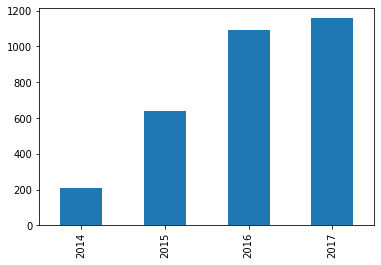

In [52]:
df[(df['Opioid Related']==True) & (df['year']!=2018)].year.value_counts().sort_index().plot(kind='bar')

## Plot the number of fentanyl deaths by year, and the number of heroin deaths by year

- *Tip: You'll want to look up how to use `ylim` - it will let you set each graphic to use the same scale. This should be separate graphics.*
- *Tip: Pay attention to the numbers on your axes. `sort_index()` will be your friend.*
- *Tip: You should probably get rid of 2018*

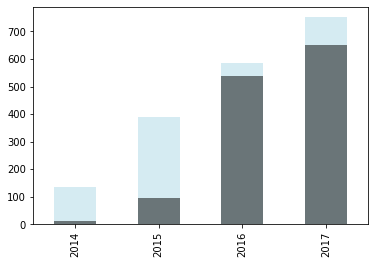

In [53]:
ax = df[(df['Opioid Related']==True) & (df['year']!=2018) & (df['Primary Cause'].str.contains("HEROIN"))].year.value_counts().sort_index().plot(kind='bar', alpha=.5, color="lightblue")

ax1 = df[(df['Opioid Related']==True) & (df['year']!=2018) & (df['Primary Cause'].str.contains("FENTANYL"))].year.value_counts().sort_index().plot(kind='bar', ax=ax,alpha=.5, color='black')

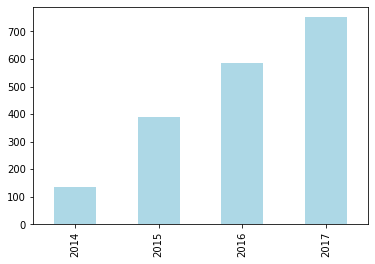

In [54]:
df[(df['Opioid Related']==True) & (df['year']!=2018) & (df['Primary Cause'].str.contains("HEROIN"))].year.value_counts().sort_index().plot(kind='bar', color="lightblue")

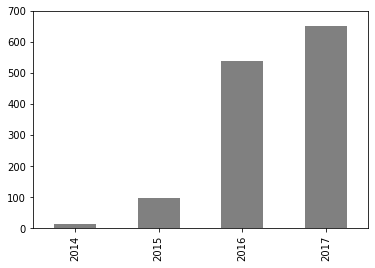

In [55]:
df[(df['Opioid Related']==True) & (df['year']!=2018) & (df['Primary Cause'].str.contains("FENTANYL"))].year.value_counts().sort_index().plot(kind='bar', ylim=(0,700), color="gray")

## How does this compare to gun deaths?

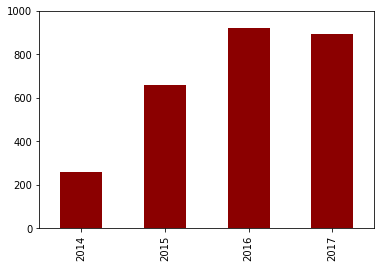

In [56]:
df[(df['year']!=2018) & (df['Primary Cause'].str.contains("GUN"))].year.value_counts().sort_index().plot(kind='bar', ylim=(0,1000), color="darkred")


## But hey: numbers can lie pretty easily!

The numbers are just so low in 2014 and much higher in 2017. What's going on there?

Well, maybe **there just isn't as much data from the earlier years**. Plot how many entries there are for each year.

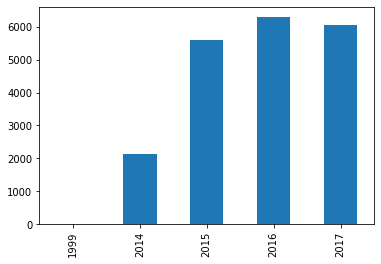

In [57]:
df[(df['year']!=2018)].year.value_counts().sort_index().plot(kind='bar')


And we don't know the best way to fix that up yet, so instead I'm going to give you a present.

# Is the true lesson here, don't move to Cook County, Illinois?

Cook County is basically Chicago. It's probably just certain areas that are trouble, right? Let's investigate that without even having a clue how mapping works.

## Fun bonus: Making cheating maps

### Make a new dataframe of every death in the actual city of Chicago

In [58]:
chicago_df = df[df['Incident City'].str.contains(r"^CHICAGO$", na=False)]

### Confirm this new dataframe has 13,627 rows

In [59]:
chicago_df.shape

(13627, 21)

### Use lat and long in the worst way possible to make a map

Use `longitude` and `latitude` and `plot` to make a rough map of the city. Chicago [looks like this](https://en.wikipedia.org/wiki/File:DuPage_County_Illinois_Incorporated_and_Unincorporated_areas_Chicago_Highlighted.svg)

- *Tip: Use the `latitude` and `longitude` columns*
- *Tip: You don't want a line graph, of course. Or a bar. What kind is the kind with dots on it?*
- *Tip: Use something like like `figsize=(10,5)` to specify the height and width of the map (but, you know, with better numbers that make it look like chicago)*

C:\Users\sawye\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


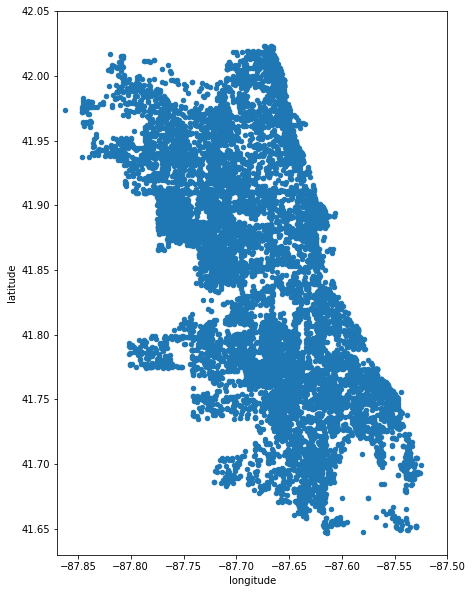

In [60]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

all_hom = chicago_df.plot(kind='scatter', x='longitude', y='latitude', figsize=(7,10), ylim=(41.63, 42.05), xlim=(-87.87, -87.5), ax=ax1)

## Now let's find out where to live

Make a map of every non-homicide death in Chicago, then plot the homicides on top of it.

Use the `ax=df.plot` trick from the beer cans assignment to plot all of the rows representing homicides vs non-homicides. You can use `color='red'` to make one of them red, and `alpha=0.05` to make each mark very transparent to allow them to layer on top of each other.

C:\Users\sawye\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


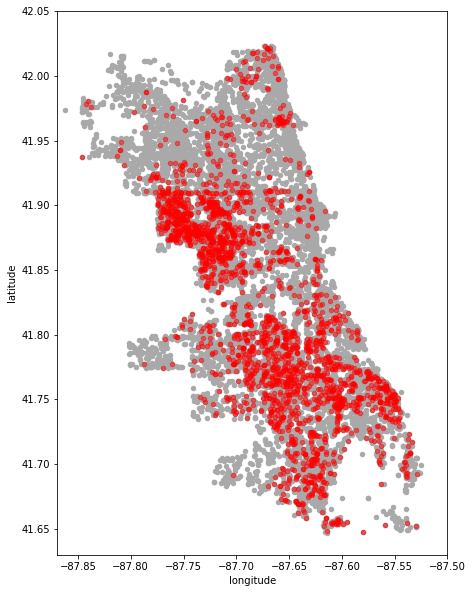

In [61]:
fig = plt.figure()
all_hom = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

chicago_df.plot(kind='scatter', x='longitude', y='latitude', figsize=(7,10), ylim=(41.63, 42.05), xlim=(-87.87, -87.5), ax=all_hom, color="darkgray")
chicago_df[chicago_df['Manner of Death']=="HOMICIDE"].plot(kind='scatter', color="red", x='longitude', y='latitude', figsize=(7,10), ylim=(41.63, 42.05), xlim=(-87.87, -87.5), ax=ax2, alpha=.5)

## Never tell anyone I let you do that.

But you want to see something actually completely legitimately insane?

**Chicago is one of the most segregated cities in America.** If you'd like to see this for yourself, make a map of `Race`. Plot black vs white in a way similar to what we did above.

In [62]:
df.Race.value_counts()

White              12425
Black               9316
Asian                340
Other                269
Unkown                26
American Indian       15
Name: Race, dtype: int64

C:\Users\sawye\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sawye\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\sawye\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


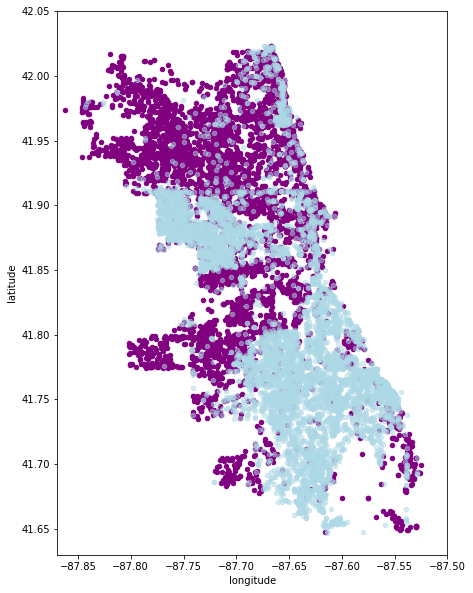

In [63]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)

chicago_df[df['Race']=="White"].plot(kind='scatter', x='longitude', y='latitude', figsize=(7,10), ylim=(41.63, 42.05), xlim=(-87.87, -87.5), ax=ax1, color="purple")
chicago_df[df['Race']=="Black"].plot(kind='scatter',x='longitude', y='latitude', figsize=(7,10), ylim=(41.63, 42.05), xlim=(-87.87, -87.5), ax=ax2, alpha=.5, color='lightblue')

Yup.